In [3]:
import numpy as np
from pydub import AudioSegment
import random
import sys
import io
import os
import glob
import librosa
import IPython
from utils import *
%matplotlib inline

In [4]:
Tx = 3600 # fft with 200 samples/frame and overlap=120-> 80 sample/frame; 6s*48000/80=3600
n_freq = 101

Ty = 897 # new_dimension = ((old_dimension - filter_size + 2 * padding) / stride ) + 1
# X = Conv1D(196, kernel_size=15, strides= 4)(X_input) -> 
sr = 48000

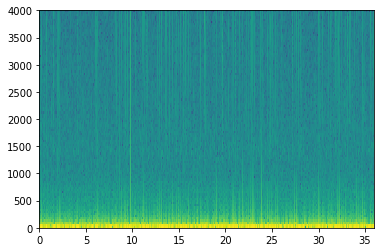

In [5]:
NGs_6s = []
for filename in os.listdir("./data/NG"):
    if filename.endswith("wav"):
        x = graph_spectrogram("./data/NG/"+filename, sec=6)
        NGs_6s.append((filename, x))

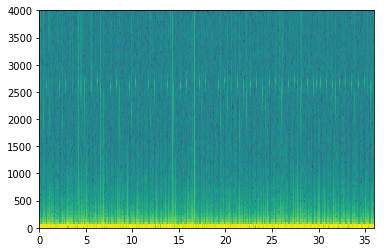

In [7]:
OKs_6s = []
count_max = len(NGs_6s)
count = 0
for filename in os.listdir("./data/OK"):
    if filename.endswith("wav"):
        count+=1
        if count>=count_max:
            break
        x = graph_spectrogram("./data/OK/"+filename, sec=6)
        OKs_6s.append((filename, x))

In [8]:
def gen_train_data_NG(data):
    
    y_arr = []
    
    for item in data:
        file = item[0]
        y = np.zeros(Ty)
        ng_parts = file.split('__')[0].split('_')
        for part in ng_parts:
            start_part = int(part.split('-')[0])
            end_part = int(part.split('-')[1])
            convert_rate = 897/3600
            start_sec = int(start_part*600*convert_rate)
            end_sec = int(end_part*600*convert_rate)
            y[start_sec:end_sec] = 1
        y_arr.append(y)
    return data, y_arr

In [9]:
X_NG, y_NG = gen_train_data(NGs_6s)

In [12]:
def gen_train_data_OK(data):
    y_arr = []
    
    for item in data:
        file = item[0]
        y = np.zeros(Ty)
        y_arr.append(y)
    return data, y_arr

In [13]:
X_OK, y_OK = gen_train_data_OK(OKs_6s)

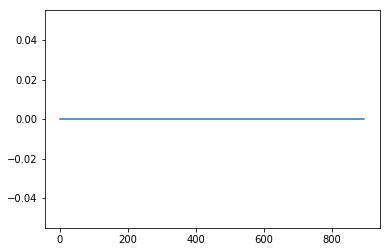

In [14]:
plt.plot(y_OK[26])

In [28]:
train_x = []
train_y = y_NG+y_OK
for x in NGs_6s:
    train_x.append(x[1])
for x in OKs_6s:
    train_x.append(x[1])

In [156]:
# import pickle
# with open('train_x.pickle', 'rb') as input:
#     train_x = pickle.load(input)
# with open('y.pickle', 'rb') as input:
#     y = pickle.load(input)

# Create data

In [50]:
from torch.utils import data

In [51]:
params = {'batch_size': 4,
          'shuffle': True,
          'num_workers': 6}
class Dataset(data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, train_data, labels):
        'Initialization'
        self.labels = labels
        self.train_data = train_data

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.train_data)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        X = self.train_data[index]
        y = self.labels[index][:896]

        return X, y

In [52]:
training_set = Dataset(train_x, train_y)
training_generator = data.DataLoader(training_set, **params)

# Model

In [54]:
import torch
import torch.nn as nn

In [55]:
Ty = 896
hidden_gru = 128

In [56]:
class GRU_CNN(nn.Module):
    def __init__(self):
        super(GRU_CNN, self).__init__()
        self.cnn1d = nn.Conv1d(101, 196, kernel_size=15, stride=4) #n_filters= 196, in_channels = 101
        
        self.gru1 = nn.GRU(196, hidden_gru, 1, batch_first=True)
        self.gru2 = nn.GRU(hidden_gru, hidden_gru, 1, batch_first=True)
        
        self.relu = nn.ReLU()
        self.bn196 = nn.BatchNorm1d(196)
        self.bn128 = nn.BatchNorm1d(128)
        self.fc = nn.Linear(hidden_gru, 1)
        self.signmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(0.8)
        

    def forward(self, x):
        #CONV1D
        out = self.cnn1d(x)
        out = self.bn196(out)
        out = self.relu(out)
        out = self.dropout(out)
        
        out = torch.transpose(out, 1, 2)
        #GRU1
        out, h =  self.gru1(out)
        out = torch.transpose(out, 1, 2)
        out = self.dropout(out)
        out = self.bn128(out)  
        
        out = torch.transpose(out, 1, 2)
        #GRU2
        out, h =  self.gru2(out)
        out = torch.transpose(out, 1, 2)
        out = self.dropout(out)
        out = self.bn128(out)  
        out = self.dropout(out)
        
        
        
        out = torch.transpose(out, 1, 2)
        out = self.fc(out)
        out = self.signmoid(out)

        return out

In [57]:
model = GRU_CNN()

In [65]:
EPOCHS = 2
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), betas=(0.9, 0.999), lr=1e-4)

In [66]:
model = model.double()
for epoch in range(1,EPOCHS+1):
    loss_at_epoch = []
    
    for data, target in training_generator:
        model.zero_grad()
        target = target[:,:,None]
        
        output = model(data)
        loss = loss_function(output, target)
        loss.backward()
        optimizer.step()

        loss_at_epoch = loss
    print("Epoch: ", epoch)
    print("Loss: {:.6f}...".format(loss_at_epoch.item()))
          
        

torch.Size([4, 896, 1])
torch.Size([4, 896, 1])
torch.Size([4, 896, 1])
torch.Size([4, 896, 1])
torch.Size([4, 896, 1])
torch.Size([4, 896, 1])
torch.Size([4, 896, 1])
torch.Size([4, 896, 1])
torch.Size([4, 896, 1])
torch.Size([4, 896, 1])
torch.Size([4, 896, 1])
torch.Size([4, 896, 1])
torch.Size([4, 896, 1])
torch.Size([4, 896, 1])
torch.Size([4, 896, 1])
torch.Size([4, 896, 1])
torch.Size([4, 896, 1])
torch.Size([4, 896, 1])
torch.Size([4, 896, 1])
torch.Size([4, 896, 1])
torch.Size([4, 896, 1])
torch.Size([4, 896, 1])
torch.Size([4, 896, 1])
torch.Size([4, 896, 1])
torch.Size([4, 896, 1])
torch.Size([4, 896, 1])
torch.Size([4, 896, 1])
torch.Size([4, 896, 1])
torch.Size([4, 896, 1])
torch.Size([4, 896, 1])
torch.Size([4, 896, 1])
torch.Size([4, 896, 1])
torch.Size([4, 896, 1])
torch.Size([4, 896, 1])
torch.Size([4, 896, 1])
torch.Size([4, 896, 1])
torch.Size([4, 896, 1])
torch.Size([4, 896, 1])
torch.Size([4, 896, 1])
torch.Size([4, 896, 1])
torch.Size([4, 896, 1])
torch.Size([4, 8

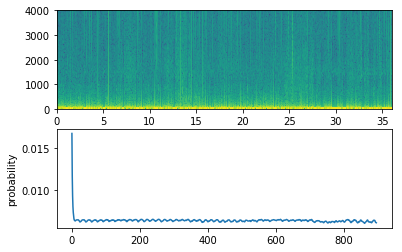

In [12]:
model.eval()
filename = '0-4_14-18__ESGAS__1_458350.wav'
plt.subplot(2, 1, 1)

x = graph_spectrogram("./data/NG/"+filename, sec=6)
# the spectrogram outputs (freqs, Tx) and we want (Tx, freqs) to input into the model
x  = x.swapaxes(0,1)
x = np.expand_dims(x, axis=0)
x = torch.from_numpy(x)
x = torch.transpose(x, 1, 2)
predictions = model(x)

predictions = predictions.detach().numpy()
plt.subplot(2, 1, 2)
plt.plot(predictions[0,:,0])
plt.ylabel('probability')
plt.show()

In [27]:
len(y_OK+y_NG)

129